<a href="https://colab.research.google.com/github/enricoaquilina/webnlg2023/blob/main/WebNLG_Task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%%capture
!pip install sentencepiece
!pip install transformers

In [3]:
import gc
import pandas as pd
import os
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration
from transformers.optimization import  Adafactor 
import time
import warnings
warnings.filterwarnings('ignore')
import os


In [4]:
import math
train_df = pd.read_csv('/content/drive/MyDrive/WebNLG/2023-Challenge/data/processed/webNLG2020_train.csv', index_col=[0])
train_df=train_df.iloc[:4500,:]
train_df=train_df.sample(frac=1)
batch_size=8
num_of_batches=math.floor(len(train_df)/batch_size)

In [5]:
num_of_batches

562

In [6]:
train_df.shape

(4500, 3)

In [7]:
train_df

,prefix,input_text,target_text
3598,webNLG,['London | leaderTitle | Parliament_of_the_Uni...,['Londra hija l-post tal-mewt għal Alfred Gart...
1993,webNLG,['Philippines | ethnicGroup | Zamboangans'],"['Zamboangani huma grupp fil-Filippini.', 'Wie..."
24,webNLG,"['Abilene_Regional_Airport | runwayName | ""17R...",['17R/35L huwa l-isem tal-runway fl-ajruport R...
1179,webNLG,['(19255)_1994_VK8 | epoch | 2006-12-31'],['L-eproku ta’ (19255) 1994 VK8 hija fil-31 ta...
3216,webNLG,['Adirondack_Regional_Airport | locationIdenti...,['L-Ajruport Reġjonali Adirondack huwa 507 met...
...,...,...,...
2771,webNLG,['AZAL_Arena | location | Shuvalan'],"['L-Arena AZAL tinsab fi Shuvalan.', 'AZAL Are..."
4353,webNLG,['Auron_(comicsCharacter) | creator | Marv_Wol...,['Marv Wolfman ħoloq il-karattru tal-kamikotik...
2611,webNLG,['Felipe_González | predecessor | Rodolfo_Llop...,"['Rodolfo Llopis qabel Felipe Gonzalez.', 'Il-..."
3541,webNLG,"[""Alison_O'Donnell | genre | Jazz"", ""Alison_O'...","[""Alison O'Donnell jindika mużika tal-ġazz u ġ..."


In [8]:
if torch.cuda.is_available():
   dev = torch.device("cuda:0")
   print("Running on the GPU")
else:
   dev = torch.device("cpu")
   print("Running on the CPU")

Running on the GPU


In [9]:
%%capture
import pandas as pd
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration,Adafactor

tokenizer = T5Tokenizer.from_pretrained('t5-base')
model = T5ForConditionalGeneration.from_pretrained('t5-base',
                                             return_dict=True)
#moving the model to device(GPU/CPU)
model.to(dev)

In [10]:
optimizer = Adafactor(
    model.parameters(),
    lr=1e-3,
    eps=(1e-30, 1e-3),
    clip_threshold=1.0,
    decay_rate=-0.8,
    beta1=None,
    weight_decay=0.0,
    relative_step=False,
    scale_parameter=False,
    warmup_init=False
)


In [11]:
from IPython.display import HTML, display

def progress(loss,value, max=100):
    return HTML(""" Batch loss :{loss}
        
            {value}
        
    """.format(loss=loss,value=value, max=max))

In [17]:
num_of_epochs=10


In [18]:
#Sets the module in training mode
model.train()

loss_per_10_steps=[]
for epoch in range(1,num_of_epochs+1):
  print('Running epoch: {}'.format(epoch))
  
  running_loss=0

  out = display(progress(1, num_of_batches+1), display_id=True)
  for i in range(num_of_batches):

    inputbatch=[]
    labelbatch=[]
    new_df=train_df[i*batch_size:i*batch_size+batch_size]
    for indx,row in new_df.iterrows():
      input = 'WebNLG: '+row['input_text']+'</s>' 
      labels = row['target_text']+'</s>'    
      inputbatch.append(input)
      labelbatch.append(labels)
    inputbatch=tokenizer.batch_encode_plus(inputbatch,padding=True,max_length=400,return_tensors='pt')["input_ids"]
    labelbatch=tokenizer.batch_encode_plus(labelbatch,padding=True,max_length=400,return_tensors="pt") ["input_ids"]
    inputbatch=inputbatch.to(dev)
    labelbatch=labelbatch.to(dev)

    # clear out the gradients of all Variables 
    optimizer.zero_grad()

    # Forward propogation
    outputs = model(input_ids=inputbatch, labels=labelbatch)
    loss = outputs.loss
    loss_num=loss.item()
    logits = outputs.logits
    running_loss+=loss_num
    if i%10 ==0:      
      loss_per_10_steps.append(loss_num)
    out.update(progress(loss_num,i, num_of_batches+1))

    # calculating the gradients
    loss.backward()

    #updating the params
    optimizer.step()
  
  running_loss=running_loss/int(num_of_batches)
  print('Epoch: {} , Running loss: {}'.format(epoch,running_loss))
  

Running epoch: 1


Epoch: 1 , Running loss: 0.3637481254667998
Running epoch: 2


Epoch: 2 , Running loss: 0.284251897135133
Running epoch: 3


Epoch: 3 , Running loss: 0.2246990940961125
Running epoch: 4


Epoch: 4 , Running loss: 0.19168576644567834
Running epoch: 5


Epoch: 5 , Running loss: 0.16820025889474727
Running epoch: 6


Epoch: 6 , Running loss: 0.1480723852656278
Running epoch: 7


Epoch: 7 , Running loss: 0.1331721676970928
Running epoch: 8


Epoch: 8 , Running loss: 0.11967037052738072
Running epoch: 9


Epoch: 9 , Running loss: 0.1088493622083787
Running epoch: 10


Epoch: 10 , Running loss: 0.09985413998895692


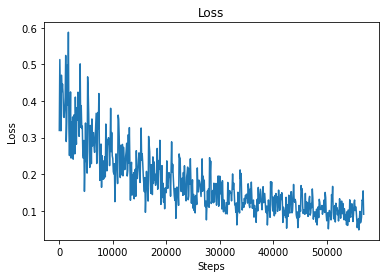

In [19]:
import matplotlib.pyplot as plt
   
steps = [i*100 for i in range(len(loss_per_10_steps))]
  
plt.plot(steps, loss_per_10_steps)
plt.title('Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.show()

In [20]:
model.eval()
input_ids = tokenizer.encode("WebNLG: Russia | leader | Putin </s>", return_tensors="pt")  # Batch size 1
input_ids=input_ids.to(dev)
outputs = model.generate(input_ids)
tokenizer.decode(outputs[0])
     

"<pad>['Il-mexxej tar-Russja hu"

In [16]:
torch.save(model.state_dict(),'pytorch_model.bin')
